# <center><ins>REIT Time Series Analysis(Ticker:RHP)<ins/><center/>

In [1]:
from module import decomposition
from module import dickey_fuller
from module import arima_endog
from module import arima_exog
from module import rmse_cv
from module import lasso_reg

import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from numpy import hstack
import warnings
import os
from fredapi import Fred
warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf


%matplotlib inline
%load_ext autoreload
%reload_ext autoreload

In [2]:
start = datetime(2000,2,1)
end = datetime(2020,1,31)

In [3]:
RHP = web.DataReader('RHP', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
RHP = RHP.copy()
RHP.to_csv('data/RHP_GRU.csv')
RHP.index = pd.to_datetime(RHP.index)
RHP = RHP.resample('MS').mean()
RHP['mid'] = (RHP['high']+RHP['low'])/2
RHP.drop(labels = ['high', 'low', 'open', 'close', 'volume'], axis = 1, inplace = True)

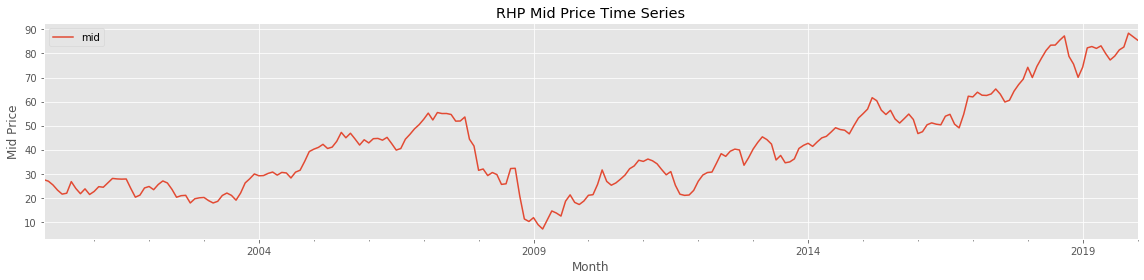

In [4]:
plt.style.use('ggplot')
RHP.plot(figsize = (16,4))
plt.xlabel('Month')
plt.ylabel('Mid Price')
plt.title('RHP Mid Price Time Series')
plt.tight_layout()
plt.show();

## <ins>Time Series Decomposition<ins/>

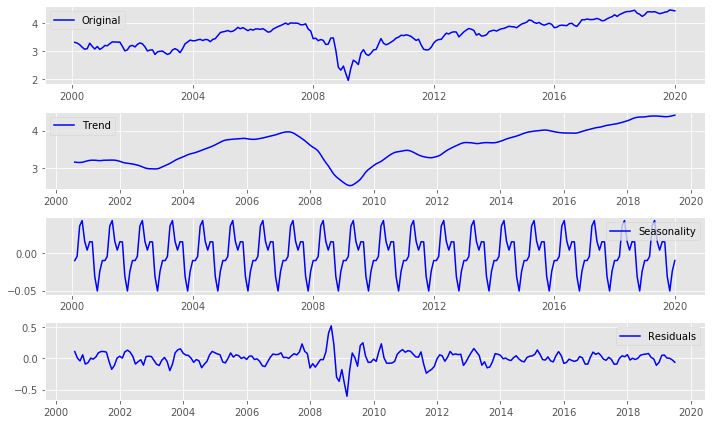

In [5]:
decomposition(RHP)

In [6]:
RHP_diff = RHP.diff(periods = 1).dropna()

In [7]:
dickey_fuller(RHP_diff)

The series passes the Dickey Fuller Test for Stationarity. P-Value = 5.91849663375333e-20


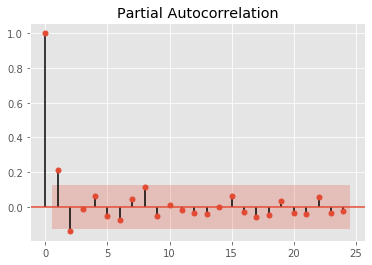

In [8]:
plot_pacf(RHP_diff);

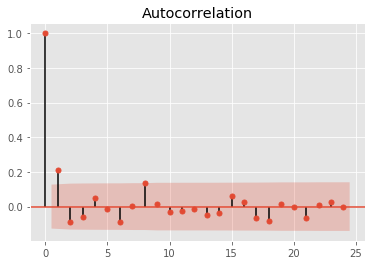

In [9]:
plot_acf(RHP_diff);

In [10]:
parameters = (2,1,5)
seasonal_parameters = (2,1,5,12)

In [11]:
RHP_train = RHP[:'2017']
RHP_test = RHP['2018':]

## <ins>SARIMAX Model w/o Exogenous Variables<ins/>

Summary:                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  215
Model:             SARIMAX(2, 1, 5)x(2, 1, 5, 12)   Log Likelihood                -342.483
Date:                            Thu, 13 Feb 2020   AIC                            716.966
Time:                                    11:53:12   BIC                            763.568
Sample:                                02-01-2000   HQIC                           735.904
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0006      0.001      0.567      0.571      -0.001       0.003
ar.L1          0.5589     

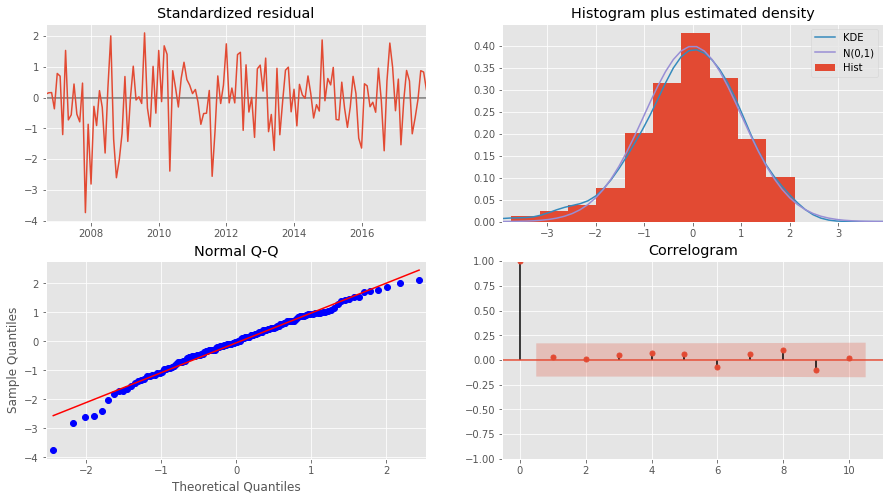

--------------------------------------------------------------------------------------------------------------------------------------------------------------
 
Predictions vs. Observed: 
 


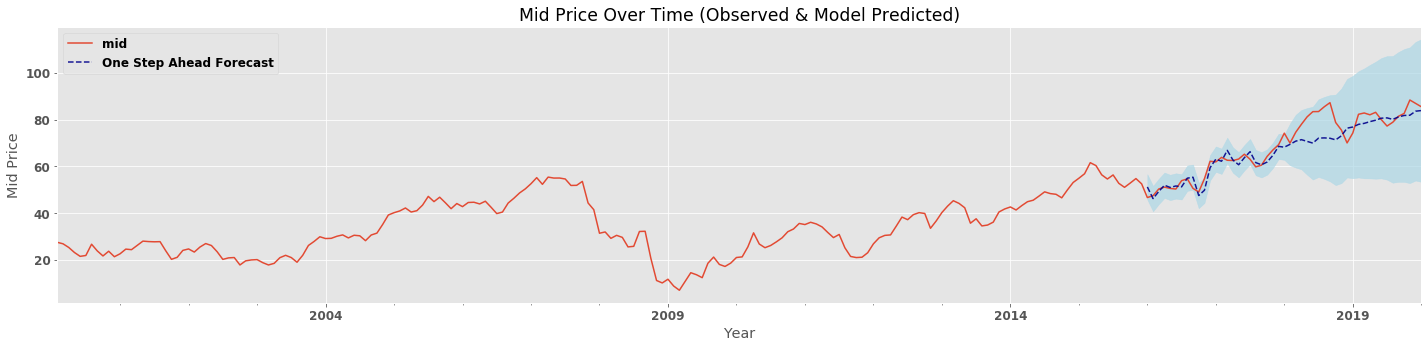

In [13]:
arima_endog(RHP_train, RHP,  parameters, seasonal_parameters)

## <ins>Determine Exogenous Feature Importance<ins/>

In [14]:
RHP_rates = pd.read_csv('data/RHP_rates.csv', index_col = 'date')

The R-score of the Lasso Regression is: 0.9759463850237745



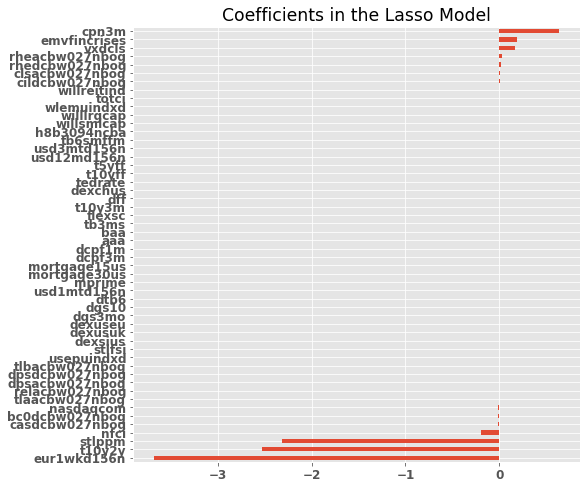

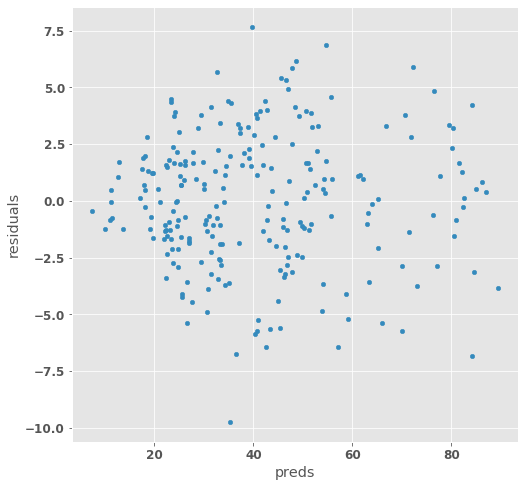

In [15]:
lasso_reg(RHP_rates)

In [16]:
RHP_rates_train = RHP_rates[:'2018']
RHP_rates_test = RHP_rates['2018':]

In [17]:
exog_train = RHP_rates_train[['eur1wkd156n', 't10y2y', 'stlppm', 'cpn3m']]

In [18]:
exog_test = RHP_rates_test[['eur1wkd156n', 't10y2y', 'stlppm', 'cpn3m']]

## <ins>SARIMAX Model w/ Exogenous Variables<ins/>

Summary:                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  215
Model:             SARIMAX(2, 1, 5)x(2, 1, 5, 12)   Log Likelihood                -347.490
Date:                            Thu, 13 Feb 2020   AIC                            734.980
Time:                                    11:56:42   BIC                            793.234
Sample:                                02-01-2000   HQIC                           758.653
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
drift           0.0002      0.001      0.269      0.788      -0.001       0.001
eur1wkd156n     1.5872 

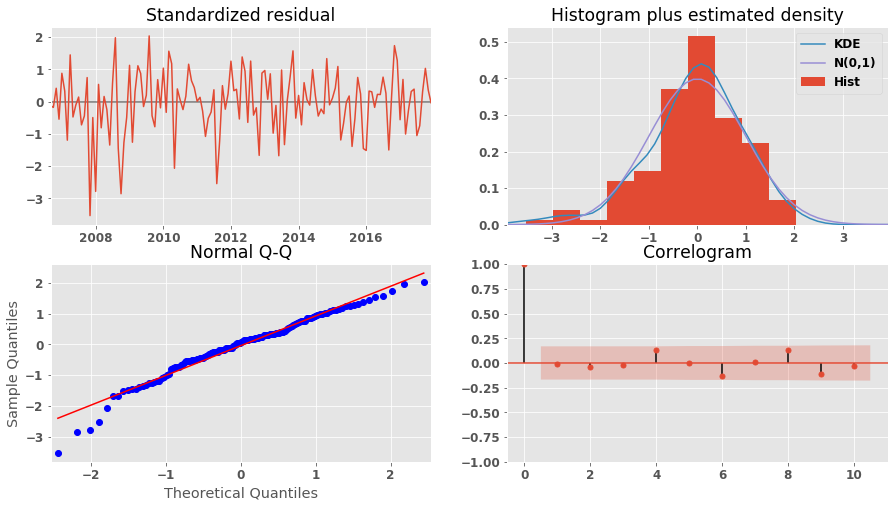

--------------------------------------------------------------------------------------------------------------------------------------------------------------
 
Predictions vs. Observed: 
 


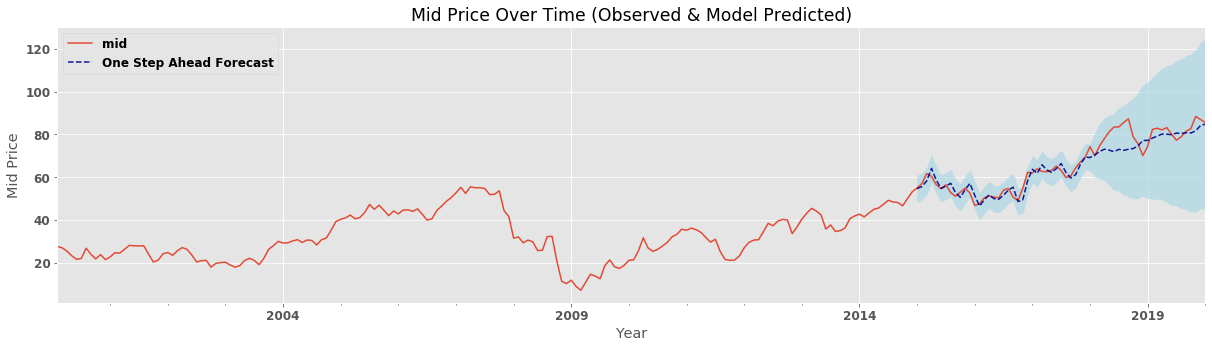

In [19]:
arima_exog(RHP_train, RHP, parameters, seasonal_parameters, exog_train, exog_test)